In [2]:
# import keras

In [3]:
# keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

# github tensorflow>tensorflow>contrib>slim for VGG

In [4]:
#import sys
#sys.path.append("$HOME/models/research/slim/")

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image


import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

/home/jk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# from tensorflow.contrib.slim.nets import vgg
from nets import vgg

In [6]:
def vgg_16(inputs,
           reuse=False,
           scope='vgg_16'):
    """Oxford Net VGG 16-Layers version D Example
    My Note: This code is modified version of vgg_16 which is loacted on `models/research/slim/nets/vgg.py`
    Note: All the fully_connected layers have been transformed to conv2d layers.
          To use in classification mode, resize input to 224x224.
    Args:
      inputs: a tensor of size [batch_size, height, width, channels].
      reuse: whether or not the model is being reused.
      scope: Optional scope for the variables.
    Returns:
      net: the output of the logits layer (if num_classes is a non-zero integer),
        or the input to the logits layer (if num_classes is 0 or None).
      end_points: a dict of tensors with intermediate activations.
    """
    with tf.variable_scope(scope, 'vgg_16', [inputs], reuse=reuse) as sc:
        end_points_collection = sc.original_name_scope + '_end_points'
        with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d],       # 일단 max 플링으로.
                            outputs_collections=end_points_collection):
            # 여기를 직접 채워 넣으시면 됩니다.
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')

            end_points = slim.utils.convert_collection_to_dict(end_points_collection)

            return net, end_points

In [7]:
inputs = tf.placeholder(tf.float32, [None, 224, 224, 3])

In [11]:
with slim.arg_scope(vgg.vgg_arg_scope()):
    outputs, end_points = vgg_16(inputs, reuse = tf.AUTO_REUSE)

In [12]:
print(outputs)

Tensor("vgg_16_1/pool5/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)


In [13]:
for node in end_points:
    print(node)

vgg_16/conv1/conv1_1
vgg_16/conv1/conv1_2
vgg_16_1/pool1
vgg_16/conv2/conv2_1
vgg_16/conv2/conv2_2
vgg_16_1/pool2
vgg_16/conv3/conv3_1
vgg_16/conv3/conv3_2
vgg_16/conv3/conv3_3
vgg_16_1/pool3
vgg_16/conv4/conv4_1
vgg_16/conv4/conv4_2
vgg_16/conv4/conv4_3
vgg_16_1/pool4
vgg_16/conv5/conv5_1
vgg_16/conv5/conv5_2
vgg_16/conv5/conv5_3
vgg_16_1/pool5


In [14]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("./graphs/01_vgg16", sess.graph)
    writer.close()

In [15]:
my_images = Image.open('baby-duck-300x225.jpg')
my_images = my_images.resize((224, 224))
my_images = np.asarray(my_images) / 255.
my_images -= 0.5
my_images *= 2.0

my_images = np.expand_dims(my_images, axis=0)

In [18]:
saver = tf.train.Saver()

with tf.Session(config=sess_config) as sess:

    # use saver object to load variables from the saved model
    saver.restore(sess, "vgg_16_ckpt/vgg_16.ckpt")

    # print conv1_1 weight itself
    conv1_1_w = sess.run(tf.trainable_variables()[0])

    # print feature maps
    conv1_1, conv2_1, \
    conv3_2, conv4_3, \
    conv5_3 = sess.run([end_points['vgg_16/conv1/conv1_1'],
                      end_points['vgg_16/conv2/conv2_1'],
                      end_points['vgg_16/conv3/conv3_2'],
                      end_points['vgg_16/conv4/conv4_3'],
                      end_points['vgg_16/conv5/conv5_3']],
                     feed_dict={inputs: my_images})

INFO:tensorflow:Restoring parameters from vgg_16_ckpt/vgg_16.ckpt


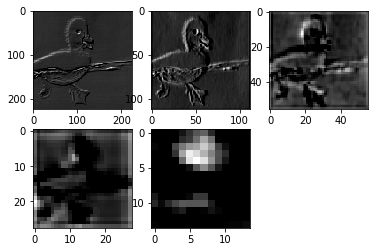

In [19]:
#plt.figure(figsize=(max_print, 1))
#plt.axis('off')
channel_index = 30
plt.subplot(231)
plt.imshow(conv1_1[0,:,:,channel_index], cmap='gray')
plt.subplot(232)
plt.imshow(conv2_1[0,:,:,channel_index], cmap='gray')
plt.subplot(233)
plt.imshow(conv3_2[0,:,:,channel_index], cmap='gray')
plt.subplot(234)
plt.imshow(conv4_3[0,:,:,channel_index], cmap='gray')
plt.subplot(235)
plt.imshow(conv5_3[0,:,:,channel_index], cmap='gray')
plt.show()